# Comparing two models

In this tutorial we will examine how to properly compare two models given the available data.

The models that we will compare both consist of a *cosine* oscillation of angular frequency $\omega$ and $\phi$. Their difference is that in the **simple model, the total amplitude is a constant**, thus having:

$$
x_{\text{simple}}(t) = A\, \cos(\omega t + \phi)
$$

whereas in the **extended model the total amplitude is linearly-evolving with time**, thus having:

$$
x_{\text{extended}}(t) = (A+B\,t)\, \cos(\omega t + \phi)
$$

We begin by first importing the required packages, including of course ``pocoMC``:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
np.random.seed(42)

## Defining the models and generating the data

We now can define both models as functions that accept an array of parameters and the time instances. We then generate the data using the *extended* model with the linearly-evolving amplitude by first specifying the true values of its parameters and then adding some Gaussian noise
to the model.

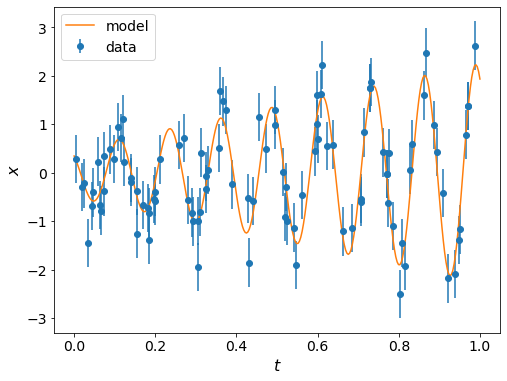

In [2]:
# Extended model with linearly-evolving amplitude
def model_extended(params, t):
    A, B, omega, phi, = params
    return (A + B * t) * np.cos(omega * t + phi)

# Simple model with constant amplitude
def model_simple(params, t):
    A, omega, phi, = params
    return A * np.cos(omega * t + phi)

# True parameters
params_true = np.array([0.5, 1.75, 50.0, 0.8])

# Time instances corresponding to available data
t = np.random.uniform(0.0, 1.0, 100)
idx = np.argsort(t)
t = t[idx]

# Standard deviation of Gaussian noise of the data
sigma = 0.5

# Simulated data
data = np.random.normal(model_extended(params_true, t), sigma) 

# Time range used for plotting only
t_range = np.linspace(0.0, 1.0, 300)

# Figure
plt.figure(figsize=(8,6))
plt.errorbar(t, data, yerr=sigma, fmt="o", label='data')
plt.plot(t_range, model_extended(params_true, t_range), label='model')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Log-likelihood, log-prior and parameter bounds

We then define the log-likelihood and log-prior functions, as well as the low & high parameter bounds. We will use the same functions for both models and provide the model as an additional argument. The parameter bounds are identical for the common parameters of the two models. The bounds of the extended model include an extra parameter of course for the linear dependance of the amplitude.

In [3]:
# Log-likelihood function used for either model
def log_like(params, t, data, sigma, model):
    m = model(params, t)
    diff = m - data
    return -0.5 * np.dot(diff, diff) / sigma**2.0

# Log-prior probability density function used for either model
def log_prior(params, bounds):
    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0

# Parameters bounds for extended model
bounds_extended = np.array([[-5.0, 5.0], # A
                            [-5.0, 5.0], # B
                            [10.0, 100.0], # omega
                            [0.0, np.pi]]) # phi

# Parameters bounds for simple model
bounds_simple = np.array([[-5.0, 5.0], # A
                          [10.0, 100.0], # omega
                          [0.0, np.pi]]) # phi

## Initialising and running Preconditioned Monte Carlo

Once we generate some initial positions for the particles by sampling from the prior we are ready to initialise the sampler and run PMC to get the results. We do this two times, once for the extended model and once for the simple model.

### Extended model

In [4]:
# Number of particles to use
n_particles = 1000

# Number of parameters of extended model
n_dim_extended = 4

# Prior samples for the extended model
prior_samples_extended = np.random.uniform(low = bounds_extended.T[0],
                                           high = bounds_extended.T[1],
                                           size = (n_particles, n_dim_extended))

# Initialise sampler for extended model
sampler_extended = pc.Sampler(n_particles = n_particles,
                              n_dim = n_dim_extended,
                              log_likelihood = log_like,
                              log_prior = log_prior,
                              bounds = bounds_extended,
                              loglikelihood_args = [t, data, sigma, model_extended],
                              logprior_args = [bounds_extended]
                              )

# Run sampler and add extra samples at the end
sampler_extended.run(prior_samples_extended)
sampler_extended.add_samples(2000)

# Get results
results_extended = sampler_extended.results

Iter: 19it [01:08,  4.03s/it, beta=0.0368, calls=71000, ESS=0.951, logZ=-10.5, accept=0.226, N=2, scale=0.665, corr=0.875]/Users/minas/opt/anaconda3/envs/dev-env/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 40it [03:31,  5.29s/it, beta=1, calls=135000, ESS=0.991, logZ=-56.6, accept=0.251, N=2, scale=1.09, corr=0.744]     
Iter: 2it [00:00,  6.48it/s, beta=1, calls=140000, ESS=0.95, logZ=-56.6, accept=0.243, N=3, scale=1.12, corr=0.668]


### Simple model

In [5]:
# Number of parameters of simple model
n_dim_simple = 3

# Prior samples of simple model
prior_samples_simple = np.random.uniform(low = bounds_simple.T[0],
                                         high = bounds_simple.T[1],
                                         size = (_particles, n_dim_simple))

# Initialise sampler for simple model
sampler_simple = pc.Sampler(n_particles = n_particles,
                            n_dim = n_dim_simple,
                            log_likelihood = log_like,
                            log_prior = log_prior,
                            bounds_simple,
                            loglikelihood_args = [t, data, sigma, model_simple],
                            logprior_args = [bounds_simple]
                            )

# Run sampler and add extra samples at the end
sampler_simple.run(prior_samples_simple)
sampler_simple.add_samples(2000)

# Get results
results_simple = sampler_simple.results

Iter: 35it [02:21,  4.04s/it, beta=1, calls=83000, ESS=0.969, logZ=-76.2, accept=0.261, N=2, scale=1.12, corr=0.685]      
Iter: 2it [00:00, 10.97it/s, beta=1, calls=87000, ESS=0.95, logZ=-76.2, accept=0.278, N=2, scale=1.16, corr=0.691]


## Bayes factor and model comparison

Now that both runs are complete, we can use the estimates of the logarithm of the model evidence $\log \mathcal{Z}$ for the two models to compute the so--called Bayes factor $BF_{es} = \exp(\log\mathcal{Z}_{ext}-\log\mathcal{Z}_{simple})$, which under the assumption of equally probable models a-priori expresses the posterior odds of the extended model to the simple model i.e. how much more probable is that the data were generated by the extended rather than the simple model.

In [6]:
# Bayes factor of extended to simple model
BF = np.exp(results_extended['logz'][-1]-results_simple['logz'][-1])

print('The extended model is '+str(np.round(BF,2))+' times more probable than the simple model.')

The extended model is 325221246.8 times more probable than the simple model.


It is important to mention here that there some caveats in the use of Bayes factors for model comparison.
- First of all, the estimates of the model evidences $\mathcal{Z}$ that constitute the numerator and denominator of the Bayes factor are subject to noise.
- The Bayes factor is very much prior dependent, so if you cannot provide well-justified priors then do not use it.
- Even if you can provide well-justified priors, keep in mind that any small uncertainty in the exact form of the priors can lead to $\mathcal{O}(1)$ effects on the Bayes factor. So do not over-interpret it, especially if it is of order $\mathcal{O}(1)$.
- Finally, all models are wrong. The Bayes factor will only inform you of the most probable model, but keep in mind that there is a good chance that none of the models that you are comparing is the "correct" one.